# Import images 

In [49]:
# !pip install tensorflow-macos
# !pip install tensorflow-hub
# !pip install tensorflow-datasets

In [50]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

import pandas as pd

import matplotlib.pyplot as plt


In [51]:
# Formatting the column display in jupyter labs
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", 200)
pd.set_option('display.max_colwidth', None)

In [52]:
print(tf.__version__)

2.11.0


### move pictures to subfolders

In [53]:
file_list = pd.read_csv('data/fish_data/images/list.csv', header=None)
file_list.columns = ['index_2', 'pre_folder_name', 'controlled_info', 'combined', 'pre_file_name']

#file_list['file_name'] = '/Users/nlory/.keras/datasets/fish_photos/numbered/' + file_list['pre_file_name'].astype(str) + '.png'
#file_list['folder_name'] = '/Users/nlory/.keras/datasets/fish_photos/numbered/' + file_list['pre_folder_name'].astype(str) + '/'
#file_list['file_name_new'] = file_list['folder_name'].astype(str) + file_list['pre_file_name'].astype(str) + '.png'

# Path inside data folder
file_list['file_name'] = 'data/fish_data/images/numbered/' + file_list['pre_file_name'].astype(str) + '.png'
file_list['folder_name'] = 'data/fish_data/images/numbered/' + file_list['pre_folder_name'].astype(str) + '/'
file_list['file_name_new'] = file_list['folder_name'].astype(str) + file_list['pre_file_name'].astype(str) + '.png'


df = file_list[['file_name','folder_name', 'file_name_new', 'pre_file_name', 'pre_folder_name']].copy()
df


,file_name,folder_name,file_name_new,pre_file_name,pre_folder_name
0,data/fish_data/images/numbered/1.png,data/fish_data/images/numbered/A73EGS-P/,data/fish_data/images/numbered/A73EGS-P/1.png,1,A73EGS-P
1,data/fish_data/images/numbered/2.png,data/fish_data/images/numbered/A73EGS-P/,data/fish_data/images/numbered/A73EGS-P/2.png,2,A73EGS-P
2,data/fish_data/images/numbered/3.png,data/fish_data/images/numbered/A73EGS-P/,data/fish_data/images/numbered/A73EGS-P/3.png,3,A73EGS-P
3,data/fish_data/images/numbered/4.png,data/fish_data/images/numbered/A73EGS-P/,data/fish_data/images/numbered/A73EGS-P/4.png,4,A73EGS-P
4,data/fish_data/images/numbered/5.png,data/fish_data/images/numbered/A73EGS-P/,data/fish_data/images/numbered/A73EGS-P/5.png,5,A73EGS-P
...,...,...,...,...,...
4406,data/fish_data/images/numbered/4407.png,data/fish_data/images/numbered/zeus_faber/,data/fish_data/images/numbered/zeus_faber/4407.png,4407,zeus_faber
4407,data/fish_data/images/numbered/4408.png,data/fish_data/images/numbered/zeus_faber/,data/fish_data/images/numbered/zeus_faber/4408.png,4408,zeus_faber
4408,data/fish_data/images/numbered/4409.png,data/fish_data/images/numbered/zeus_faber/,data/fish_data/images/numbered/zeus_faber/4409.png,4409,zeus_faber
4409,data/fish_data/images/numbered/4410.png,data/fish_data/images/numbered/zeus_faber/,data/fish_data/images/numbered/zeus_faber/4410.png,4410,zeus_faber


In [54]:
# Read the CSV file into a DataFrame

# Iterate through the rows of the DataFrame
for index, row in df.iterrows():
    # Get the file name and folder name from the CSV
    file_name = row['file_name']
    folder_name = row['folder_name']
    # Create the folder if it doesn't already exist
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    # Move the file to the new folder
    os.rename(file_name, row['file_name_new'])

FileNotFoundError: [Errno 2] No such file or directory: 'data/fish_data/images/numbered/1.png' -> 'data/fish_data/images/numbered/A73EGS-P/1.png'

In [55]:
# The data contains 193 different families of fish divided into 483 species of fish. 
# Classifiying only on the family level would therefore only double the number of images per class, 
# without assuring a consistent number of images per class

#file_list = pd.read_csv('data/fish_data/list.csv', header=None)
#file_list.columns = ['index_2', 'pre_folder_name', 'controlled_info', 'combined', 'pre_file_name']
#
#file_list_2 = file_list['pre_folder_name'].str.split('\_', expand=True)
#file_list_2.columns = ['family','species','subspecies']
#
#file_list = pd.concat([file_list, file_list_2], axis=0, ignore_index=True)
#
#
#file_list['file_name'] = '/Users/nlory/.keras/datasets/fish_photos/numbered/' + file_list['pre_file_name'].astype(str) + '.png'
#file_list['folder_name'] = '/Users/nlory/.keras/datasets/fish_photos/numbered/' + file_list['pre_folder_name'].astype(str) + '/'
#file_list['file_name_new'] = file_list['folder_name'].astype(str) + file_list['pre_file_name'].astype(str) + '.png'
#
#df = file_list[['file_name','folder_name', 'file_name_new', 'pre_file_name', 'pre_folder_name', 'family','species']].copy()
#df
#file_list_2
#df['family'].nunique()

### import to keras/tensorflow

[https://www.tensorflow.org/tutorials/load_data/images](https://www.tensorflow.org/tutorials/load_data/images)

In [56]:
import pathlib
from pathlib import Path

In [57]:
data_dir = Path('data/fish_data/images/numbered')


In [58]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)


4411


In [59]:
batch_size = 32
img_height = 180
img_width = 180


In [60]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 4411 files belonging to 483 classes.
Using 3529 files for training.


In [61]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 4411 files belonging to 483 classes.
Using 882 files for validation.


In [62]:
class_names = train_ds.class_names
print(class_names)

['A73EGS-P', 'CUNWCB-Y', 'Istiophorus_platypterus', 'P1ROZC-Z', 'PQV7DP-S', 'acanthaluteres_brownii', 'acanthaluteres_spilomelanurus', 'acanthaluteres_vittiger', 'acanthistius_cinctus', 'acanthopagrus_australis', 'acanthopagrus_berda', 'acanthopagrus_latus', 'achoerodus_gouldii', 'achoerodus_viridis', 'acreichthys_tomentosus', 'aesopia_cornuta', 'aethaloperca_rogaa', 'alectis_ciliaris', 'alectis_indica', 'alepes_kleinii', 'aluterus_monoceros', 'aluterus_scriptus', 'amanses_scopas', 'anampses_caeruleopunctatus', 'anampses_elegans', 'anampses_femininus', 'anampses_geographicus', 'anampses_lennardi', 'anampses_melanurus', 'anampses_meleagrides', 'anampses_neoguinaicus', 'anampses_twistii', 'anodontostoma_chacunda', 'anyperodon_leucogrammicus', 'aphareus_furca', 'aphareus_rutilans', 'aprion_virescens', 'argyrops_spinifer', 'aseraggodes_melanostictus', 'atractoscion_aequidens', 'atule_mate', 'auxis_rochei', 'auxis_thazard', 'bathylagichthys_greyae', 'beryx_decadactylus', 'bodianus_anthioide

2023-01-25 16:44:30.578820: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


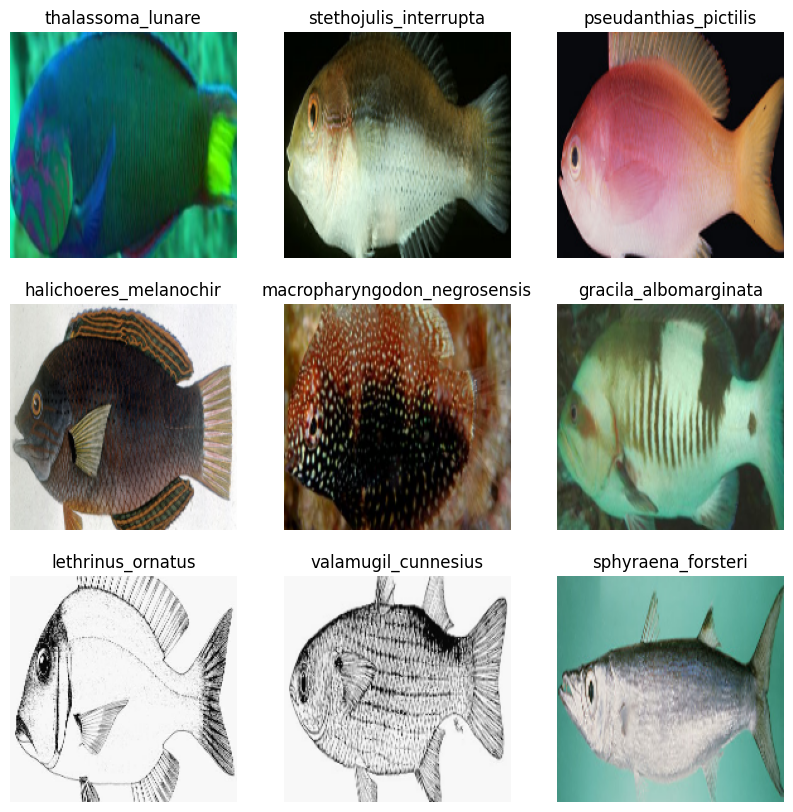

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [64]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 180, 180, 3)
(32,)


In [65]:
# normalize color values
normalization_layer = tf.keras.layers.Rescaling(1./255)


In [66]:
# optional: apply normailzation to the dataset
#normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]
## Notice the pixel values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))


### Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

* Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
* Dataset.prefetch overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the Prefetching section of the Better performance with the tf.data API guide. [link](https://www.tensorflow.org/guide/data_performance)

In [67]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# First test model

In [68]:
num_classes = 483

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


In [69]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [70]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=6
)


Epoch 1/6
111/111 [==============================] - 30s 264ms/step - loss: 6.1527 - accuracy: 0.0065 - val_loss: 6.0708 - val_accuracy: 0.0079
Epoch 2/6
111/111 [==============================] - 29s 264ms/step - loss: 5.9008 - accuracy: 0.0179 - val_loss: 5.8587 - val_accuracy: 0.0306
Epoch 3/6
111/111 [==============================] - 30s 269ms/step - loss: 5.4432 - accuracy: 0.0510 - val_loss: 5.4294 - val_accuracy: 0.0692
Epoch 4/6
111/111 [==============================] - 30s 273ms/step - loss: 4.5675 - accuracy: 0.1414 - val_loss: 5.0848 - val_accuracy: 0.1179
Epoch 5/6
111/111 [==============================] - 31s 280ms/step - loss: 3.4322 - accuracy: 0.2967 - val_loss: 5.2617 - val_accuracy: 0.1542
Epoch 6/6
111/111 [==============================] - 32s 287ms/step - loss: 2.4918 - accuracy: 0.4460 - val_loss: 5.5936 - val_accuracy: 0.1565


### save test-model
[tutorial to save models](https://www.tensorflow.org/tutorials/keras/save_and_load)

In [ ]:
# !pip install pyyaml h5py  # Required to save models in HDF5 format

In [71]:
# import os
# import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)


2.11.0


In [72]:
# save the model: 

model.save('models/230125_first_test_model')
# tf.saved_model.save(model, "models/230125_first_test_model_2")

INFO:tensorflow:Assets written to: models/230125_first_test_model/assets


INFO:tensorflow:Assets written to: models/230125_first_test_model/assets


# transformer CNN

[transformer tutorial](https://keras.io/examples/vision/image_classification_with_vision_transformer/)

In [73]:
!pip install -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 4.7 MB/s eta 0:00:004.8 MB/s eta 0:00:01


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa


In [ ]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")




169001437/169001437 [==============================] - 65s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [ ]:
# x_train
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


ValueError: in user code:

    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/engine/base_preprocessing_layer.py", line 122, in adapt_step  *
        self._adapt_maybe_build(data)
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/engine/base_preprocessing_layer.py", line 295, in _adapt_maybe_build  **
        self.build(data_shape)
    File "/Users/nlory/neue_fische/ds-Capstone_Fish_Project/.venv/lib/python3.9/site-packages/keras/layers/preprocessing/normalization.py", line 172, in build
        input_shape = tf.TensorShape(input_shape).as_list()

    ValueError: as_list() is not defined on an unknown TensorShape.


[geeksforgeeks page](https://www.geeksforgeeks.org/python-image-classification-using-keras/)